In [1]:
import torch
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt

from tqdm import tqdm

In [2]:
# some imports and plot definitions

import torch
import numpy as np
import scipy
import os
from tqdm import tqdm
from scipy.optimize import NonlinearConstraint

import torch.optim as optim
import torch.nn as nn

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc

rc('text', usetex=True)
plt.rc('font', family='serif')

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Nimbus Roman"],
    "mathtext.fontset": "cm",
    "font.size": 30,
})

label_font_size = 32
title_font_size = 32

# make directories
directories = ["models", "plots", "results"]
for d in directories:
    if not os.path.exists(d):
        os.makedirs(d)

In [3]:
# our target distribution
class Helix:

    def __init__(self, r=1, sigma=8):
        self.sigma = sigma
        self.r = r
    def sample(self, num_samples):
        z = (torch.rand(num_samples)-0.5)*self.sigma 

        samples = torch.zeros([num_samples, 3])

        samples[:, 0] = self.r * torch.sin(z)
        samples[:, 1] = self.r * torch.cos(z)
        samples[:, 2] = z

        return samples
    
    def get_class(self, samples):
        return (samples[:, 2]>0).to(dtype=torch.float32)
    
    def dist(self, sample):
        
        sample_np = sample.numpy()
        
        def f(z):
            return np.array([self.r * np.sin(z), self.r * np.cos(z), z])


        def objective(X):
            return np.linalg.norm(X - sample_np)


        def con(X):
            z = X[2]
            return np.linalg.norm(f(z) - X)


        x0 = f(sample_np[2])

        nlc = NonlinearConstraint(con, 0.0, 0.0)
        X_sol = scipy.optimize.minimize(objective, x0, args=(), method='SLSQP', constraints=nlc)
        
        return np.linalg.norm(X_sol.x - sample_np)

In [4]:
# plot function
def scatter_plot(ax, samples, title=' ', lim_min=None, lim_max=None, alpha=1.0, s=1, color=None, label=None):
    ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], alpha=alpha, s=s, c=color, label=label)
    ax.set_title(title, fontsize=title_font_size)
    ax.set_xlabel("\n"+r"$x_1$")
    ax.set_ylabel("\n"+r"$x_2$")
    ax.set_zlabel("\n"+r"$x_3$")
    if lim_min is not None and lim_max is not None:
        ax.set_xlim(lim_min[0], lim_max[0])
        ax.set_ylim(lim_min[1], lim_max[1])
        ax.set_zlim(lim_min[2], lim_max[2])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman


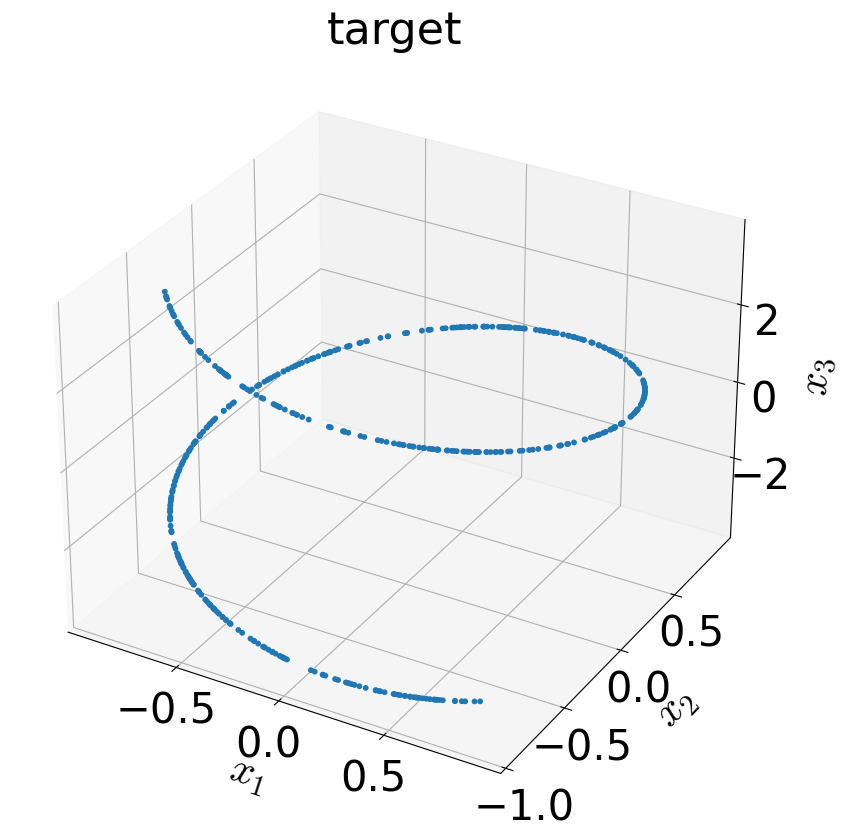

In [5]:
target_distr = Helix()

samples_target = target_distr.sample(500)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
mini = torch.min(samples_target).detach().numpy()
maxi = torch.max(samples_target).detach().numpy()
lim_min = [mini, mini, mini]
lim_max = [maxi, maxi, maxi]

lim_min = torch.min(samples_target, dim=0)[0].detach().numpy()
lim_max = torch.max(samples_target, dim=0)[0].detach().numpy()
scatter_plot(ax, samples_target.detach().numpy(), 'target', lim_min, lim_max, s=10)
plt.show()

In [45]:
import normflows as nf

# 3D Gaussian base distribution 정의
base = nf.distributions.base.DiagGaussian(3)

# 흐름(Flow) 레이어 리스트 정의
num_layers = 32
flows = []
for i in range(num_layers):
    # 3차원을 위해 마지막 레이어의 출력 차원을 3으로 조정
    param_map = nf.nets.MLP([1, 64, 64, 3], init_zeros=True)

    # Affine Coupling Block 추가
    flows.append(nf.flows.AffineCouplingBlock(param_map))

    # 차원 순서 변경
    # 3차원의 경우, 순서 변경 방식을 적절히 조정해야 할 수 있음
    flows.append(nf.flows.Permute(3, mode='swap'))

In [46]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

In [47]:
# Train model
max_iter = 4000
num_samples = 2 ** 9
show_iter = 500
batch_size = 400

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    # x = target.sample(num_samples).to(device)
    x = target_distr.sample(batch_size).to(device)
    
    # Compute loss
    loss = model.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

  0%|          | 0/4000 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (400x2 and 1x64)